In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# ===============================
# Paths (adjust if needed)
# ===============================
base_path = "archive/train"

# Remove .DS_Store if present
for root, dirs, files in os.walk(base_path):
    for f in files:
        if f.startswith("."):  # catches .DS_Store and other hidden files
            try:
                os.remove(os.path.join(root, f))
                print(f"Removed hidden file: {os.path.join(root, f)}")
            except Exception as e:
                print(f"Could not remove {f}: {e}")

print("Classes:", [d for d in os.listdir(base_path) if not d.startswith('.')])


Removed hidden file: archive/train/.DS_Store
Classes: ['Late_blight', 'Septoria_leaf_spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'healthy', 'Early_blight', 'Leaf_Mold']


In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [5]:
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training"
)

Found 13038 images belonging to 6 classes.


In [6]:
val_set = train_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation"
)

Found 3256 images belonging to 6 classes.


In [7]:
# Helper function to plot training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()

In [8]:
inception = InceptionV3(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)
for layer in inception.layers:
    layer.trainable = False

2025-09-05 00:56:32.423117: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-05 00:56:32.423166: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-05 00:56:32.423170: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-05 00:56:32.423218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-05 00:56:32.423236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 373s 4us/step


In [9]:
x = Flatten()(inception.output)
prediction = Dense(len(train_set.class_indices), activation='softmax')(x)
model_incep = Model(inputs=inception.input, outputs=prediction)

In [10]:
model_incep.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [11]:
model_incep.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,109,990 (84.34 MB)

 Trainable params: 307,206 (1.17 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [12]:
# Train
history_incep = model_incep.fit(
    train_set,
    validation_data=val_set,
    epochs=10
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-09-05 01:02:49.668996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


408/408 ━━━━━━━━━━━━━━━━━━━━ 162s 379ms/step - accuracy: 0.7100 - loss: 2.1330 - val_accuracy: 0.7835 - val_loss: 1.5084
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 160s 392ms/step - accuracy: 0.8603 - loss: 0.8968 - val_accuracy: 0.8065 - val_loss: 1.6862
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 158s 386ms/step - accuracy: 0.8916 - loss: 0.7114 - val_accuracy: 0.7767 - val_loss: 2.6505
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 157s 385ms/step - accuracy: 0.9218 - loss: 0.5012 - val_accuracy: 0.8044 - val_loss: 2.3913
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 158s 387ms/step - accuracy: 0.9474 - loss: 0.3272 - val_accuracy: 0.7743 - val_loss: 3.4489
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 157s 385ms/step - accuracy: 0.9468 - loss: 0.3430 - val_accuracy: 0.8010 - val_loss: 2.7250
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 156s 383ms/step - accuracy: 0.9580 - loss: 0.2729 - val_accuracy: 0.8182 - val_loss: 2.6764
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 156s 383ms/step - accuracy: 0.9434 - loss: 0.47

In [13]:
model_incep.save("model_inceptionv3.h5")

In [14]:
# Evaluate
score_train = model_incep.evaluate(train_set, verbose=2)
score_val = model_incep.evaluate(val_set, verbose=2)
print(f"InceptionV3 -> Train Acc: {score_train[1]*100:.2f}%, Val Acc: {score_val[1]*100:.2f}%")

408/408 - 122s - 299ms/step - accuracy: 0.9505 - loss: 0.3906
102/102 - 30s - 290ms/step - accuracy: 0.8025 - loss: 4.3181
InceptionV3 -> Train Acc: 95.05%, Val Acc: 80.25%


In [15]:
# ===============================
# Model 2: VGG19
# ===============================
vgg19 = VGG19(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)
for layer in vgg19.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 473s 6us/step


In [16]:
x = Flatten()(vgg19.output)
prediction = Dense(len(train_set.class_indices), activation='softmax')(x)
model_vgg = Model(inputs=vgg19.input, outputs=prediction)



In [17]:
model_vgg.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)



In [18]:
model_vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │       150,534 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,174,918 (76.96 MB)

 Trainable params: 150,534 (588.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
# Train
history_vgg = model_vgg.fit(
    train_set,
    validation_data=val_set,
    epochs=10
)

Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.7039 - loss: 0.8424 - val_accuracy: 0.7948 - val_loss: 0.6022
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.8566 - loss: 0.4074 - val_accuracy: 0.7869 - val_loss: 0.6148
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.9047 - loss: 0.2725 - val_accuracy: 0.8464 - val_loss: 0.4533
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.9469 - loss: 0.1693 - val_accuracy: 0.8566 - val_loss: 0.4329
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.9671 - loss: 0.1230 - val_accuracy: 0.7955 - val_loss: 0.6703
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.9701 - loss: 0.1081 - val_accuracy: 0.8474 - val_loss: 0.4813
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.9794 - loss: 0.0797 - val_accuracy: 0.8489 - val_loss: 0.4908
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.9919 - loss: 0.0516 - val_accu

model_vgg.save("model_vgg19.h5")


In [20]:
# Evaluate
score_train = model_vgg.evaluate(train_set, verbose=2)
score_val = model_vgg.evaluate(val_set, verbose=2)
print(f"VGG19 -> Train Acc: {score_train[1]*100:.2f}%, Val Acc: {score_val[1]*100:.2f}%")

408/408 - 306s - 751ms/step - accuracy: 0.9964 - loss: 0.0338
102/102 - 65s - 633ms/step - accuracy: 0.8489 - loss: 0.5608
VGG19 -> Train Acc: 99.64%, Val Acc: 84.89%


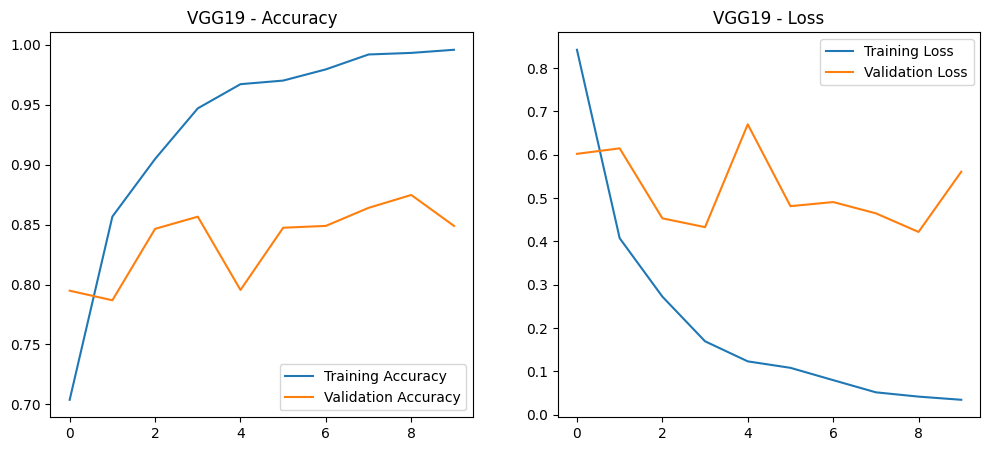

In [21]:
plot_history(history_vgg, "VGG19")

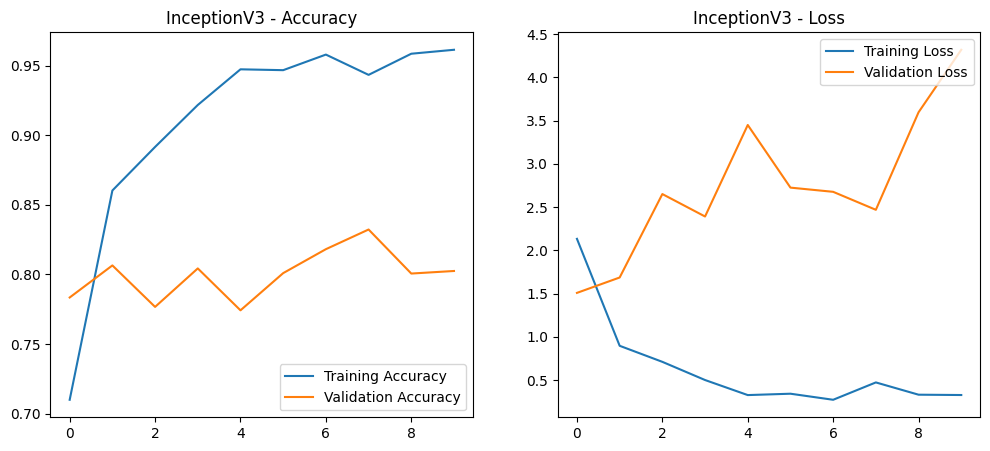

In [22]:

plot_history(history_incep, "InceptionV3")



Testing on images in test/:

Image: mold.jpeg
Predicted: Septoria_leaf_spot (76.79% confidence)
  1. Septoria_leaf_spot: 76.79%
  2. Early_blight: 23.21%
  3. Leaf_Mold: 0.00%


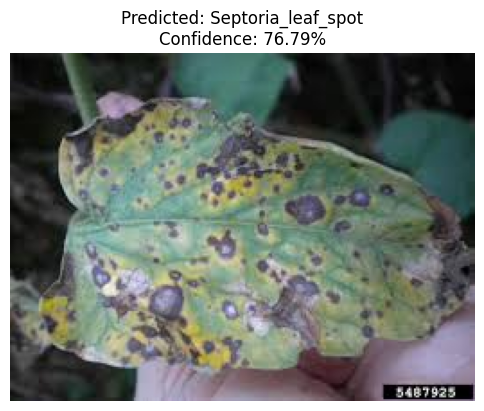


Image: late-blight.jpeg
Predicted: Early_blight (99.99% confidence)
  1. Early_blight: 99.99%
  2. Late_blight: 0.01%
  3. Leaf_Mold: 0.00%


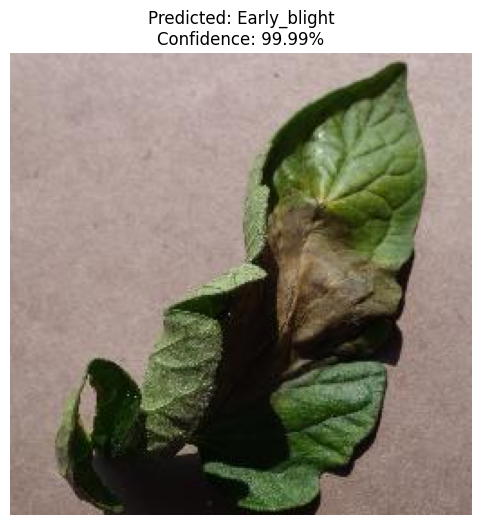


Image: healthy.jpeg
Predicted: healthy (100.00% confidence)
  1. healthy: 100.00%
  2. Leaf_Mold: 0.00%
  3. Late_blight: 0.00%


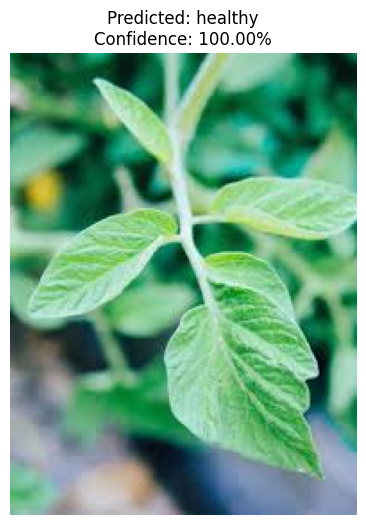


Image: early_blight2.jpeg
Predicted: Late_blight (66.50% confidence)
  1. Late_blight: 66.50%
  2. Early_blight: 33.50%
  3. Septoria_leaf_spot: 0.00%


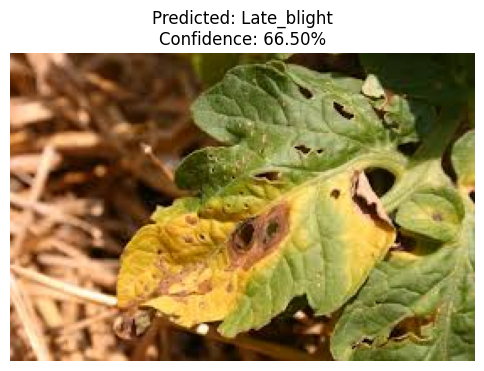


Image: yellow.jpeg
Predicted: Tomato_Yellow_Leaf_Curl_Virus (100.00% confidence)
  1. Tomato_Yellow_Leaf_Curl_Virus: 100.00%
  2. healthy: 0.00%
  3. Septoria_leaf_spot: 0.00%


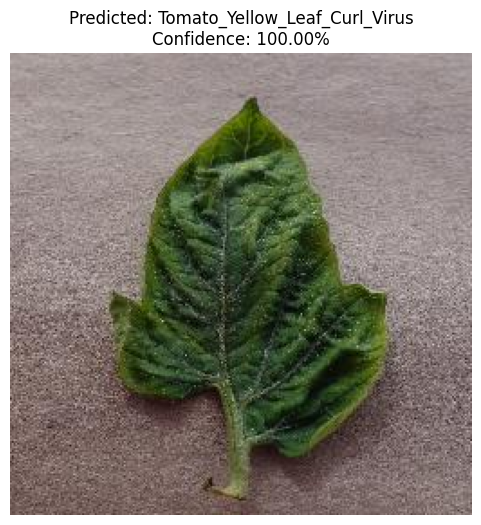


Image: sept2.jpeg
Predicted: Septoria_leaf_spot (100.00% confidence)
  1. Septoria_leaf_spot: 100.00%
  2. Early_blight: 0.00%
  3. Leaf_Mold: 0.00%


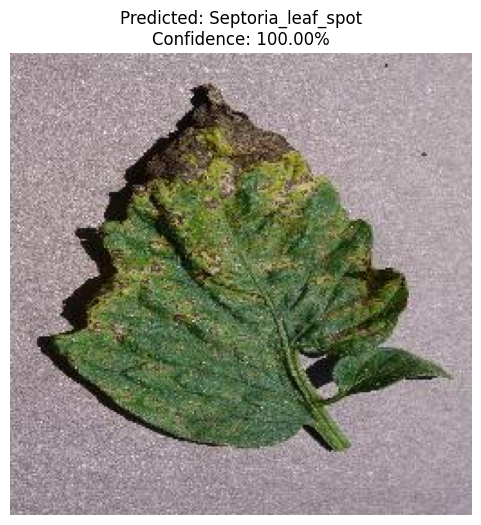


Image: curl.jpeg
Predicted: Leaf_Mold (73.14% confidence)
  1. Leaf_Mold: 73.14%
  2. Septoria_leaf_spot: 25.31%
  3. Late_blight: 1.55%


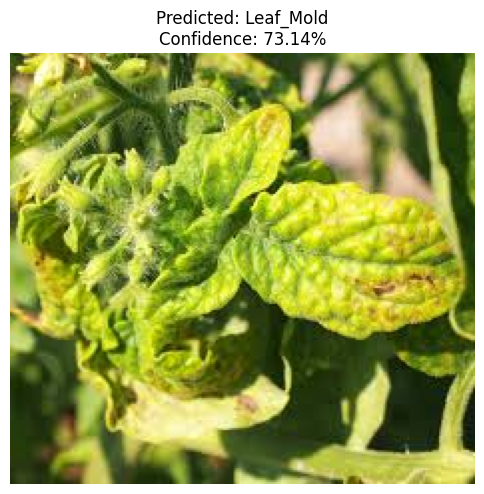


Image: yello_leaf.jpeg
Predicted: Septoria_leaf_spot (92.75% confidence)
  1. Septoria_leaf_spot: 92.75%
  2. Leaf_Mold: 6.26%
  3. Late_blight: 0.99%


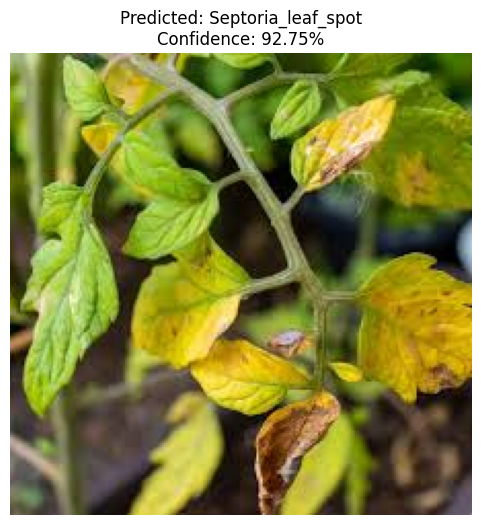


Image: early_blight.jpeg
Predicted: Septoria_leaf_spot (99.99% confidence)
  1. Septoria_leaf_spot: 99.99%
  2. Leaf_Mold: 0.01%
  3. Late_blight: 0.00%


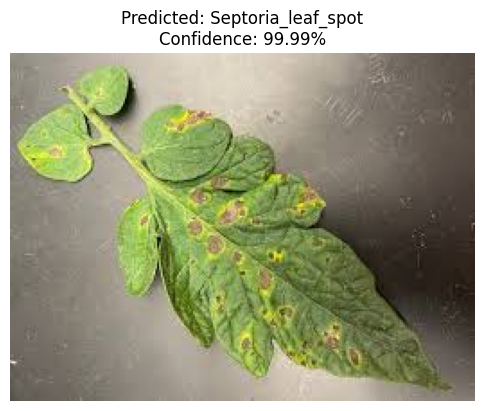


Image: mold2.jpeg
Predicted: Leaf_Mold (100.00% confidence)
  1. Leaf_Mold: 100.00%
  2. Late_blight: 0.00%
  3. healthy: 0.00%


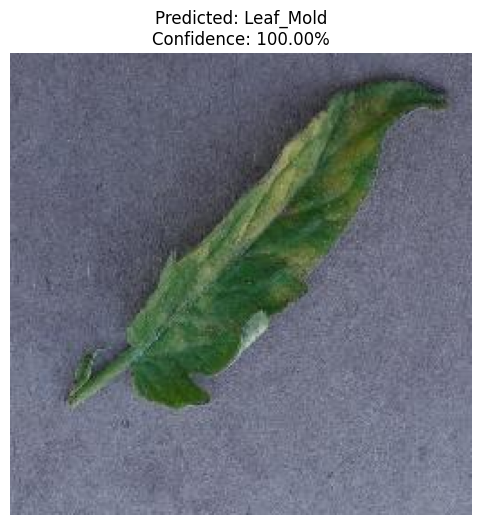


Image: early-blight3.jpeg
Predicted: Late_blight (100.00% confidence)
  1. Late_blight: 100.00%
  2. Early_blight: 0.00%
  3. Leaf_Mold: 0.00%


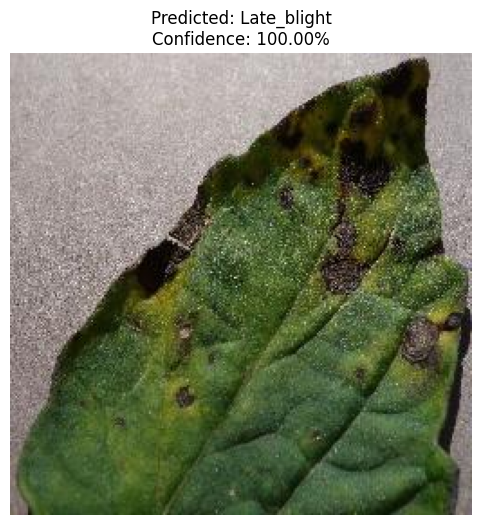


Image: sept.jpeg
Predicted: Septoria_leaf_spot (99.17% confidence)
  1. Septoria_leaf_spot: 99.17%
  2. Early_blight: 0.83%
  3. Late_blight: 0.00%


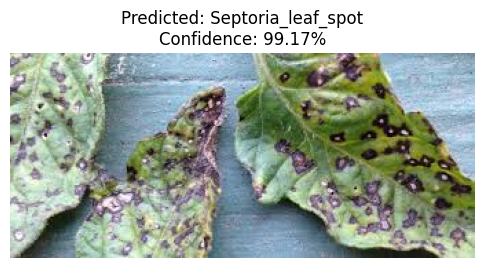

In [26]:
import cv2
# Load the trained inception model
model_incep = tf.keras.models.load_model("model_inceptionv3.h5")

# Class labels (same order as training)
classes = list(train_set.class_indices.keys())

# Function to preprocess and prepare image for prediction
def prepare_image(filepath, target_size=IMAGE_SIZE):
    img = tf.keras.utils.load_img(filepath, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array = img_array / 255.0  # rescale like training
    return img_array

# Prediction function
def predict_image(filepath):
    img_array = prepare_image(filepath)
    prediction = model_incep.predict(img_array, verbose=0)
    idx = np.argmax(prediction)
    return classes[idx], prediction

# Test directory
TEST_DIR = "test/"

if os.path.exists(TEST_DIR):
    print(f"\nTesting on images in {TEST_DIR}:")
    for img_name in os.listdir(TEST_DIR):
        img_path = os.path.join(TEST_DIR, img_name)

        # Skip hidden files like .DS_Store
        if img_name.startswith("."):
            continue

        try:
            predicted_class, prediction = predict_image(img_path)
            confidence = np.max(prediction) * 100

            print(f"\nImage: {img_name}")
            print(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)")

            # Top 3 predictions
            top3_idx = np.argsort(prediction[0])[-3:][::-1]
            for i, idx in enumerate(top3_idx):
                print(f"  {i+1}. {classes[idx]}: {prediction[0][idx]*100:.2f}%")

            # Show the image with matplotlib
            img_display = cv2.imread(img_path)
            img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(6, 6))
            plt.imshow(img_display)
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Could not process {img_name}: {e}")